In [1]:
#imports go here

from sage.plot.polygon import Polygon
from sage.plot.colors import rainbow

In [2]:
# OK we still have two problems:
#     - Because of how the substitution rule plays out, we end up defining the same prototile twice, and then 4 times if you substitute another time, and then 8 times for yet another time (it's an exponential situation very sad)
#     - Also because of this, I have not yet figured out the relation between level and number of prototiles


# This lets us not have to create a new matrix object every time we need to do a rotation.
# Just index into the dictionary with the angle you need to rotate by.

rot = {
    0 : matrix(2,2,[cos(0),-sin(0),sin(0),cos(0)]),
    pi/5 : matrix(2,2,[cos(pi/5),-sin(pi/5),sin(pi/5),cos(pi/5)]),
    2*pi/5: matrix(2,2,[cos(2*pi/5),-sin(2*pi/5),sin(2*pi/5),cos(2*pi/5)]),
    3*pi/5 : matrix(2,2,[cos(3*pi/5),-sin(3*pi/5),sin(3*pi/5),cos(3*pi/5)]),
    4*pi/5 : matrix(2,2,[cos(4*pi/5),-sin(4*pi/5),sin(4*pi/5),cos(4*pi/5)]),
    pi : matrix(2,2,[cos(pi),-sin(pi),sin(pi),cos(pi)]),
    6*pi/5 : matrix(2,2,[cos(6*pi/5),-sin(6*pi/5),sin(6*pi/5),cos(6*pi/5)]),
    7*pi/5 : matrix(2,2,[cos(7*pi/5),-sin(7*pi/5),sin(7*pi/5),cos(7*pi/5)]),
    8*pi/5 : matrix(2,2,[cos(8*pi/5),-sin(8*pi/5),sin(8*pi/5),cos(8*pi/5)]),
    9*pi/5 : matrix(2,2,[cos(9*pi/5),-sin(9*pi/5),sin(9*pi/5),cos(9*pi/5)]),
}

kite = 0
dart = 1



# Call this isntead of using rot directly. This way we don't have to hard-code
# all of the angles for a given substitution.
def rotate(theta):
    if rot[theta]:
        return rot[theta]
    rot[theta] = matrix(2,2,[cos(theta),-sin(theta),sin(theta),cos(theta)])
    return rot[theta]

# Calculates theta mod 2pi, assuming theta is in the range [0, 4pi)
def mod_2pi (theta):
    if theta >= 2*pi:
        return theta - 2*pi
    return theta



# TODO: Refactor this code to minimize time to generate tiles. Use a dictionary to describe 
# different supertiles for faster generation. 

class PenroseTile:
    
    # We define a supertile by:
    # level, i.e. n where the supertile is L_n
    # orientation as a multiple of pi describing rotation around its center
    # origin, describing where to place this tile when moving up a level. The origin is the point that stays fixed
    #     when moving up a level.    
    def __init__(self, shape: int, level: int, orientation, origin: vector, parent):
        self.points = []
        self.shape = shape
        self.level = level
        self.orientation = mod_2pi(orientation)
        self.origin = origin
        self.id = 0
        self.adj = None
        self.vert_map = None
        self.prototile_ids = None

        # Track the supertile containing this tile. This way, we can keep an adjacency matrix
        # or a vert_map as a class variable, but still have the subtiles refer to the matrix/map
        # of the largest supertile. 
        if parent == None:
            self.parent = self
            self.vert_map = {}
            self.prototile_ids = []
            self.adj = None
        else:
            self.parent = parent
        

        if (level < 0):
            raise Exception("Level must be a non-negative integer.")
            
        #TODO: Add 2 extra vertices for between the long ends, to make it clearer
        if (level == 0):
            if self.parent.level != 0:
                self.id = self.parent.id
                self.parent.id += 1
            self.parent.prototile_ids.append(self)
            
            # dart prototile points
            if self.shape == dart:
                self.points = [vector(QQ[sin(pi/5)], (0 + origin[0], 0 + origin[1])),
                               vector(QQ[sin(pi/5)], (sin(pi/5) + origin[0], cos(pi/5) + origin[1])), 
                               vector(QQ[sin(pi/5)], (0 + origin[0], sec(pi/5)/2 + origin[1])),
                               vector(QQ[sin(pi/5)], (-sin(pi/5) + origin[0], cos(pi/5) + origin[1]))]
            
            # kite prototile points
            if self.shape == kite:
                self.points = [vector(QQ[sin(pi/5)], (0 + origin[0], 0 + origin[1])),
                               vector(QQ[sin(pi/5)], (cos(3*pi/10) + origin[0], sin(3*pi/10) + origin[1])), 
                               vector(QQ[sin(pi/5)], (0 + origin[0], sin(3*pi/10) + sin(pi/10)*sec(pi/5)/2 + origin[1])),
                               vector(QQ[sin(pi/5)], (-cos(3*pi/10) + origin[0], sin(3*pi/10) + origin[1]))]
                
            self.rotate_tile(origin, rotate(self.orientation))

            for p in self.points:
                l = tuple(p)
                if self.parent.vert_map.get(l):
                    self.parent.vert_map[l].append(self)
                else:
                    self.parent.vert_map[l] = [self]
                    
        else:
            # If this is a supertile, we consider it to be the collection of all the prototiles that make it up
            self.subtiles = list()
            st_1 = None
            st_2 = None
            st_3 = None
            st_4 = None
            
            
            # DART SUBSTITUTION RULE
            
            if self.shape == dart:
                new_origin = vector(QQ[sin(pi/5)], self.origin)
                st_1 = PenroseTile(kite, level - 1, self.orientation, origin, self.parent)   

                # new_origin = vector(QQ[sin(pi/5)], (((2*cos(pi/5))**level) * rotate(self.orientation) * vector(QQ[sin(pi/5)], (-sin(pi/5), cos(pi/5))) + origin))
                # new_orientation = mod_2pi(self.orientation + 6*pi/5)
                # attr = (level - 1, new_orientation, (new_origin[0], new_origin[1]), dart)
                # if (attr not in self.parent.levels[level-1]):
                #     st_2 = PenroseTile(dart, level - 1, new_orientation, new_origin, self.parent)          
                #     self.parent.levels[level-1].add(attr)

                new_origin = vector(QQ[sin(pi/5)], (((2*cos(pi/5))**level) * rotate(self.orientation) * vector(QQ[sin(pi/5)], (sin(pi/5), cos(pi/5))) + origin))
                new_orientation = mod_2pi(self.orientation + 4*pi/5)
                st_3 = PenroseTile(dart, level - 1, new_orientation, new_origin, self.parent)
                        
            # KITE SUBSTITUTION RULE            
            if self.shape == kite:        
                # new_origin = vector(QQ[sin(pi/5)], self.origin)
                # new_orientation = mod_2pi(self.orientation + 9*pi/5)
                # attr = (level - 1, new_orientation, (new_origin[0], new_origin[1]), dart)
                # if (attr not in self.parent.levels[level-1]):
                #     st_1 = PenroseTile(dart, level - 1, new_orientation, origin, self.parent)
                #     self.parent.levels[level-1].add(attr)

                new_origin = vector(QQ[sin(pi/5)], self.origin)
                new_orientation = mod_2pi(self.orientation + pi/5)
                st_2 = PenroseTile(dart, level - 1, new_orientation, origin, self.parent)

                new_origin = vector(QQ[sin(pi/5)], ((2*cos(pi/5))**level) * rotate(self.orientation) * vector(QQ[sin(pi/5)], (sin(pi/5), cos(pi/5))) + self.origin)
                new_orientation = mod_2pi(self.orientation + 3*pi/5)
                st_3 = PenroseTile(kite, level - 1, new_orientation, new_origin, self.parent)
                    
                new_origin = vector(QQ[sin(pi/5)], ((2*cos(pi/5))**level) * rotate(self.orientation) * vector(QQ[sin(pi/5)], (-sin(pi/5), cos(pi/5))) + self.origin)
                new_orientation = mod_2pi(self.orientation + 7*pi/5)
                st_4 = PenroseTile(kite, level - 1, new_orientation, new_origin, self.parent)
               

            if st_1 != None:
                self.subtiles.append(st_1)
            if st_2 != None:
                self.subtiles.append(st_2)
            if st_3 != None:
                self.subtiles.append(st_3)
            if st_4 != None:
                self.subtiles.append(st_4)
      
    # Rotates a tile around a point, where mat is the rotation matrix for the degree of rotation
    # hey after rotating a tile dont we need to update the origin and the orientation?
    def rotate_tile(self, center, mat):
        if self.level == 0:
            pts = [vector(QQ[sin(pi/5)], mat*vector(QQ[sin(pi/5)], (p[0]-center[0],p[1]-center[1]))) for p in self.points]
            self.points = [vector(QQ[sin(pi/5)], (p[0]+center[0],p[1]+center[1])) for p in pts]
        else:
            for c in self.subtiles:
                c.rotate_tile(center, mat)

    # graphs a supertile            
    def graph(self, show_subtiles, dartcolor='red', kitecolor='blue'):
        P = Graphics()
        if self.level > 0:
            if self.parent == self and show_subtiles:
                colors = ['yellow', 'green', 'red', 'blue']
                i = 0
                for s in self.subtiles:
                    P += s.graph(False, colors[i], colors[i])
                    i += 1
            else:
                for s in self.subtiles:
                    P += s.graph(False, dartcolor, kitecolor)
        else:
            if self.shape == dart:
                fill_color = dartcolor
            else:
                fill_color = kitecolor
            P += polygon(self.points, fill=True, alpha=0.2, thickness=1, edgecolor='black', rgbcolor = fill_color, axes=False)
        
        return P
    
     # Display a tile, graphically. Useful for bug-fixing and testing.
    def show_tile(self):
        return polygon(self.points, fill=True, alpha=0.1, thickness=1, edgecolor='black')
    
    #Builds the adjacency matrix
    def build_adj_matrix (self):
        self.parent.adj = [[0 for i in range(self.parent.id)] for j in range(self.parent.id)]
        
        for pt in self.vert_map:
            tiles = self.vert_map[pt]
            for i in range(len(tiles)):
                for j in range(i, len(tiles)):
                    self.adj[tiles[i].id][tiles[j].id] = self.adj[tiles[j].id][tiles[i].id] = 1

    # Finds the border between the level n-1 supertiles within this tile by examining the adjacency matrix
    # while ignoring the tiles which don't have a k-collar (i.e. those which have the outside of the supertile
    # within their k-neighborhood)
    def find_border_matrix(self, k_neighborhood):
        if self.adj == None:
            raise Exception("Adjacency matrix must be built first")
        
        self.border_tiles = set()
        
        for i in range(1,4):
            # We want to break up the matrix into 16 squares, and mark tiles a,b as border tiles if 
            # adj[a.id][b.id] = 1 and adj[a.id][b.id] is in one of the six bottom-left squares
            for j in range(i):
                # Search the square of size 4**(level-1) which is at (i,j) in the matrix
                for k in range(i * 4**(self.level-1), (i+1) * 4**(self.level-1)):
                    for l in range(j * 4**(self.level-1), (j+1) * 4**(self.level-1)):
                        if self.adj[k][l] == 1:
                            self.border_tiles.add(self.prototile_ids[k])
                            self.border_tiles.add(self.prototile_ids[l])

        # We want to remove tiles which have the outside of the supertile within their k-neighborhood. We can do this by first
        # finding the tiles which are directly connected to the supertile boundary, and then find which prototiles have any of those
        # within their (k-1)-neighborhoods. We find the first set by iterating over each tile's edges and finding those edges which
        # only border one prototile. The next set is found by the adjacency matrix. 
        tiles_to_remove = set()
        
        for tile in self.border_tiles:
            for i in range(len(tile.points)):
                # Two points which are on an edge are always 'next to' each other in the points list.
                if len(set(self.vert_map[tile.points[i]]) & set(self.vert_map[tile.points[(i + 1) % len(tile.points)]])) == 1:
                    tiles_to_remove.add(tile)

        # Remove the (k-1)-neighbors of the tiles we found
        if k_neighborhood >= 1:
            #TODO: find (k-1)-neighbors of every boundary tile, THEN remove things close to the edge
            
            matrix_k = (Matrix(self.adj))^(k_neighborhood-1)
            neighborhoods_to_remove = set()
            for t in self.border_tiles - tiles_to_remove:
                for b in tiles_to_remove:
                    if matrix_k[b.id,t.id] >= 1:
                        neighborhoods_to_remove.add(t)

            tiles_to_remove = tiles_to_remove.union(neighborhoods_to_remove)

        

        self.border_tiles = self.border_tiles - tiles_to_remove

Rotated by 0*pi/5


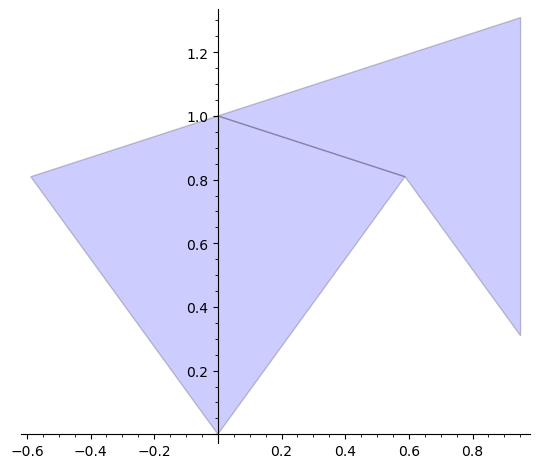

(0, 0)
0
(-4*a^3 + 3*a, -2*a^2 + 2)
4/5*pi
Rotated by 1*pi/5


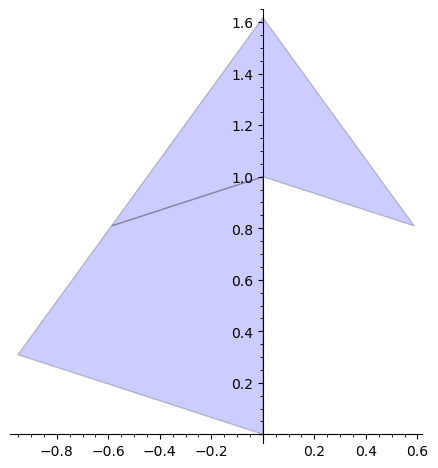

(0, 0)
1/5*pi
(0, -4*a^2 + 3)
pi
Rotated by 2*pi/5


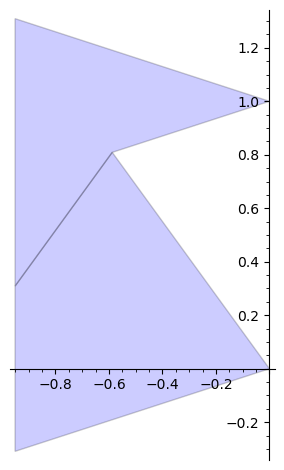

(0, 0)
2/5*pi
(4*a^3 - 3*a, -2*a^2 + 2)
6/5*pi
Rotated by 3*pi/5


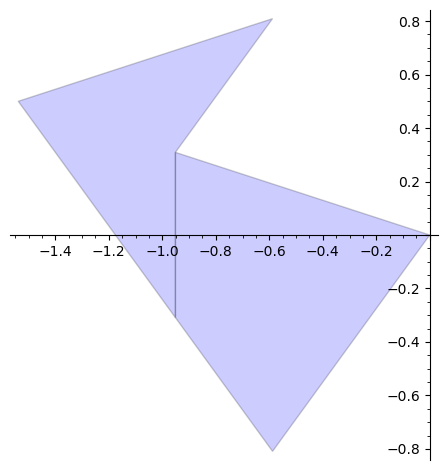

(0, 0)
3/5*pi
(4*a^3 - 4*a, 1/2)
7/5*pi
Rotated by 4*pi/5


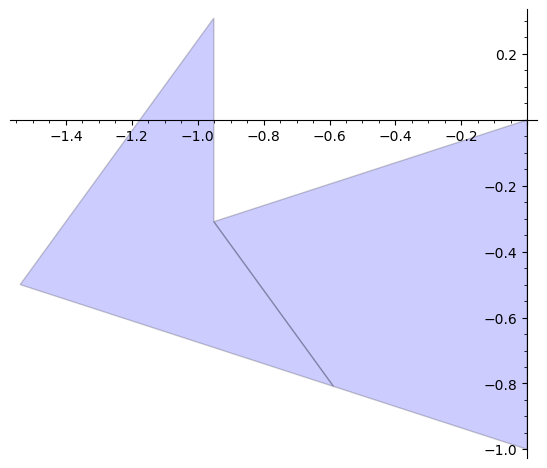

(0, 0)
4/5*pi
(4*a^3 - 4*a, -1/2)
8/5*pi
Rotated by 5*pi/5


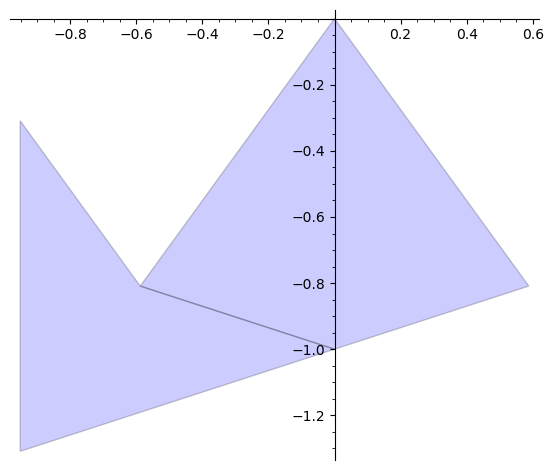

(0, 0)
pi
(4*a^3 - 3*a, 2*a^2 - 2)
9/5*pi
Rotated by 6*pi/5


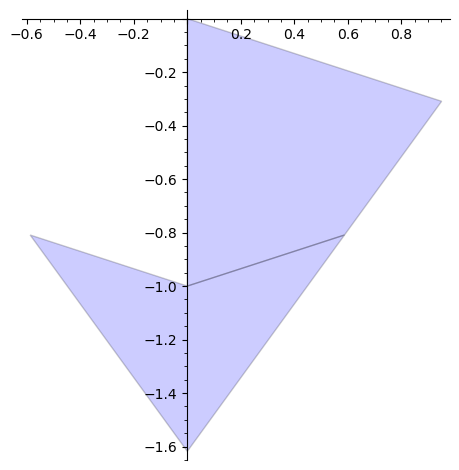

(0, 0)
6/5*pi
(0, 4*a^2 - 3)
0
Rotated by 7*pi/5


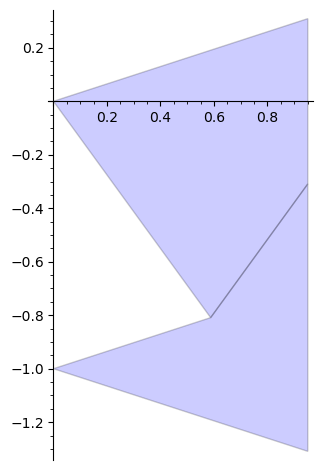

(0, 0)
7/5*pi
(-4*a^3 + 3*a, 2*a^2 - 2)
1/5*pi
Rotated by 8*pi/5


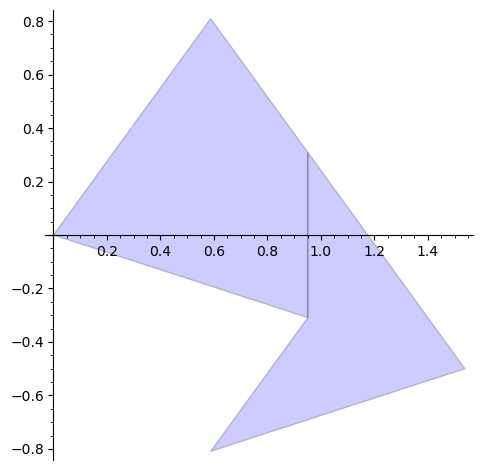

(0, 0)
8/5*pi
(-4*a^3 + 4*a, -1/2)
2/5*pi
Rotated by 9*pi/5


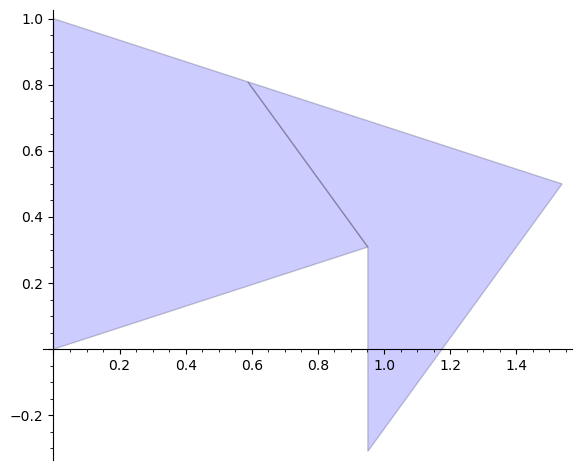

(0, 0)
9/5*pi
(-4*a^3 + 4*a, 1/2)
3/5*pi


In [34]:
for i in range(10):
    print(f"Rotated by {i}*pi/5")
    test2 = PenroseTile(dart, 1, i*pi/5, vector(QQ[sin(pi/5)], (0,0)), None)
    
    P = test2.graph(false, 'red')
    P.show()
    
    for t1 in test2.subtiles:
        print(t1.origin)
        print(t1.orientation)

In [46]:
a = sin(pi/5)
substitutions = {
    "D0" : (("D4", vector(QQ[sin(pi/5)], (-4*a^3 + 3*a, -2*a^2 + 2))), ("K0", vector(QQ[sin(pi/5)], (0,0)))),
    "D1" : (("D5", vector(QQ[sin(pi/5)], (0, -4*a^2 + 3))), ("K1", vector(QQ[sin(pi/5)], (0,0)))),
    "D2" : (("D6", vector(QQ[sin(pi/5)], (4*a^3 - 3*a, -2*a^2 + 2))), ("K2", vector(QQ[sin(pi/5)], (0,0)))),
    "D3" : (("D7", vector(QQ[sin(pi/5)], (4*a^3 - 4*a, 1/2))), ("K3", vector(QQ[sin(pi/5)], (0,0)))),
    "D4" : (("D8", vector(QQ[sin(pi/5)], (4*a^3 - 4*a, -1/2))), ("K4", vector(QQ[sin(pi/5)], (0,0)))),
    "D5" : (("D9", vector(QQ[sin(pi/5)], (4*a^3 - 3*a, 2*a^2 - 2))), ("K5", vector(QQ[sin(pi/5)], (0,0)))),
    "D6" : (("D0", vector(QQ[sin(pi/5)], (0, 4*a^2 - 3))), ("K6", vector(QQ[sin(pi/5)], (0,0)))),
    "D7" : (("D1", vector(QQ[sin(pi/5)], (-4*a^3 + 3*a, 2*a^2 - 2))), ("K7", vector(QQ[sin(pi/5)], (0,0)))),
    "D8" : (("D2", vector(QQ[sin(pi/5)], (-4*a^3 + 4*a, -1/2))), ("K8", vector(QQ[sin(pi/5)], (0,0)))),
    "D9" : (("D3", vector(QQ[sin(pi/5)], (-4*a^3 + 4*a, 1/2))), ("K9", vector(QQ[sin(pi/5)], (0,0)))),
    "K0" : (("D9", vector(QQ[sin(pi/5)], (0,0))), ("K3", vector(QQ[sin(pi/5)], (-4*a^3 + 3*a, -2*a^2 + 2))), ("K7", vector(QQ[sin(pi/5)], (4*a^3 - 3*a, -2*a^2 + 2)))),
    "K1" : (("D0", vector(QQ[sin(pi/5)], (0,0))), ("K2", vector(QQ[sin(pi/5)], (-4*a^3 + 4*a, 1/2))), ("K6", vector(QQ[sin(pi/5)], (0, -4*a^2 + 3)))),
    "K2" : (("D1", vector(QQ[sin(pi/5)], (0,0))), ("K1", vector(QQ[sin(pi/5)], (-4*a^3 + 4*a, -1/2))), ("K5", vector(QQ[sin(pi/5)], (-4*a^3 + 3*a, -2*a^2 + 2)))),
    "K3" : (("D2", vector(QQ[sin(pi/5)], (0,0))), ("K0", vector(QQ[sin(pi/5)], (-4*a^3 + 3*a, 2*a^2 - 2))), ("K4", vector(QQ[sin(pi/5)], (-4*a^3 + 4*a, 1/2)))),
    "K4" : (("D3", vector(QQ[sin(pi/5)], (0,0))), ("K9", vector(QQ[sin(pi/5)], (0, 4*a^2 - 3))), ("K3", vector(QQ[sin(pi/5)], (-4*a^3 + 4*a, -1/2)))),
    "K5" : (("D4", vector(QQ[sin(pi/5)], (0,0))), ("K8", vector(QQ[sin(pi/5)], (4*a^3 - 3*a, 2*a^2 - 2))), ("K2", vector(QQ[sin(pi/5)], (-4*a^3 + 3*a, 2*a^2 - 2)))),
    "K6" : (("D5", vector(QQ[sin(pi/5)], (0,0))), ("K7", vector(QQ[sin(pi/5)], (4*a^3 - 4*a, -1/2))), ("K1", vector(QQ[sin(pi/5)], (0, 4*a^2 - 3)))),
    "K7" : (("D6", vector(QQ[sin(pi/5)], (0,0))), ("K6", vector(QQ[sin(pi/5)], (4*a^3 - 4*a, 1/2))), ("K0", vector(QQ[sin(pi/5)], (4*a^3 - 3*a, 2*a^2 - 2)))),
    "K8" : (("D7", vector(QQ[sin(pi/5)], (0,0))), ("K5", vector(QQ[sin(pi/5)], (4*a^3 - 3*a, -2*a^2 + 2))), ("K9", vector(QQ[sin(pi/5)], (4*a^3 - 4*a, -1/2)))),
    "K9" : (("D8", vector(QQ[sin(pi/5)], (0,0))), ("K4", vector(QQ[sin(pi/5)], (0, -4*a^2 + 3))), ("K8", vector(QQ[sin(pi/5)], (4*a^3 - 4*a, 1/2))))
}

# Generates a code representing an individual type of prototile. For instance, K3 represents a kite rotated by 3pi/5.
def generate_code(shape, orientation):
    result = str()
    if shape == kite:
        result += "K"
    else:
        result += "D"

    result += str(orientation / (pi/5))
    return result



# We want to redefine the Penrose substitution to handle arbitrary patches instead of specific supertiles. So, we need a new class.
# We should keep a set of prototiles in the patch, as well as a fixed origin. One can add or remove prototiles from the patch.
# One can also substitute the entire patch. This has fewer features than a supertile-style PenroseTile because it is more general.
class PenrosePatch:

    # A PenrosePatch consists of a set of prototiles, together with a fixed origin. By default, this is set to (0,0).
    # A prototile is a tuple represented as: (code, origin)
    def __init__(self, origin=vector(QQ[sin(pi/5)], (0,0))):
        self.prototiles = set()
        self.origin = origin

    # Displays the patch graphically
    def graph_patch(self):        
        return
        
    # Adds a prototile to the patch. We assume that this won't cause two prototiles to overlap, though it could if
    # used poorly. 
    def add_prototile(self, shape, origin, orientation):
        new_tile = (generate_code(shape, orientation), origin)
        self.prototiles.add(new_tile)

    # Removes a prototile with the given attributes from the patch. Returns -1 if none exists.
    def remove_prototile(self, shape, origin, orientation):
        tile_to_remove = (generate_code(shape, orientation), origin)
        return self.prototiles.remove(tile_to_remove)

    # Substitutes the entire patch, according to the substitution rule.
    def substitute_patch(self):
        for tile in self.prototiles:
            # Substitute this tile in particular.
            for t in substitutions[tile[0]]:
                # self.add_prototile(self, t

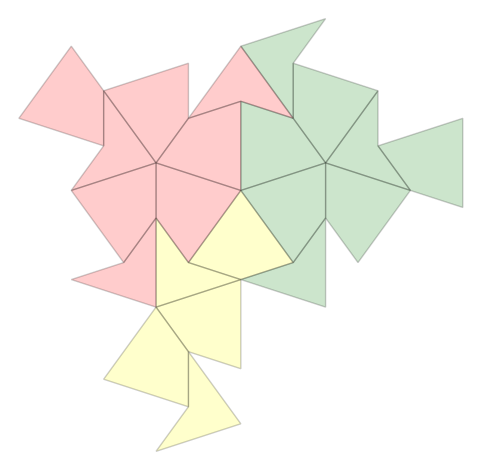

In [4]:
test = PenroseTile(kite, 3, 0, vector(QQ[sin(pi/5)], (0,0)), None)

P = test.graph(True, 'red', 'blue')

# f = 1.615
# n=6
# large_kite = polygon([(0,0), (f**n*cos(3*pi/10), f**n*sin(3*pi/10)), (0, f**n*(sin(3*pi/10) + sin(pi/10)*sec(pi/5)/2)), (-(f**n)*cos(3*pi/10), f**n*sin(3*pi/10))], 
#                      fill=false, rgbcolor='black')
# P += large_kite

P.show()
# P.save('Penrose_Dart_6_outline.png')
            

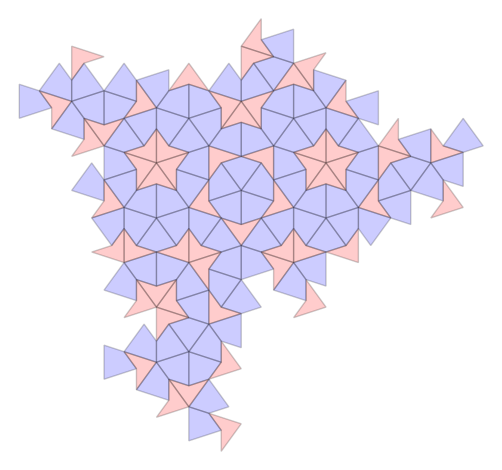

Found 124 collars in a supertile of level 5


In [27]:
# Find all the collars present within a certain supertile

sup_tile_level = 5
num_collars = 0
sup_tile = PenroseTile(kite, sup_tile_level, 0, vector(QQ[sin(pi/5)], (0,0)), None)
sup_tile.build_adj_matrix()

collars_found = set()

P = sup_tile.graph(false)
P.show()

for p_tile in sup_tile.prototile_ids:
    if (p_tile == None): break
    patch = Patch()
    
    s = find_k_neighbors(sup_tile, p_tile, 1)
    patch.add_tile(p_tile)

    for t in s:
        patch.add_tile(t)

    if patch in collars_found:
        continue

    collars_found.add(patch)
    num_collars += 1
    G = patch.display_patch(p_tile)
    G.save(f'Penrose_Collar_{num_collars}.png')

print(f"Found {num_collars} collars in a supertile of level {sup_tile_level}")

In [25]:
# A patch represents a group of tiles. Specifically, we want one to represent a group of tiles
# which are all neighboring, and which form a k-collar of the central tile. 
class Patch:
    def __init__ (self):
        self.tiles = set()
        self.parent = None
        self.hash = set()

    # Add a tile to this patch. If the patch does not yet have any tiles in it,
    # then mark its parent as the first tile added. Tiles in a patch are given as
    # lists of points relative to the parent tile, so two patches that are the same
    # up to translation are equivalent as Patch objects.
    def add_tile(self, tile):
        if self.parent == None:
            self.parent = tile

        # Maintain a list of certain values to use to hash a Patch object. Specifically,
        # we want patches to have the same hash if they have the same prototiles arranged
        # in the same way. This seems to work for now but might need tweaking in the future.
        # self.hash.add(tile.orientation)
        for p in tile.points:
            self.hash.add((tile.orientation, p[0] - self.parent.origin[0], p[1] - self.parent.origin[1]))

        tile_pts_relative = tuple((vector((p[0] - self.parent.origin[0], p[1] - self.parent.origin[1]), immutable=True) for p in tile.points))
        self.tiles.add(tile_pts_relative)

    # Displays the patch graphically, with tile marked in red.
    def display_patch (self, tile=None):
        G = Graphics()
        for t in self.tiles:
            G += polygon(t, fill=false)

        if tile != None:
            highlight_points = [vector((p[0] - self.parent.origin[0], p[1] - self.parent.origin[1])) for p in tile.points]
            G += polygon(highlight_points, fill=true, rgbcolor=(1,0,0), alpha=0.5, axes=false)
                
        return G

    def display_patch_no_highlight (self):
        G = Graphics()
        for t in self.tiles:
            G += polygon(t, fill=false)

        return G

    # Compares two patches. Specifically, this returns True if both patches have the
    # same tiles in the same relative positions. So two patches are equal if one is 
    # a translation of the other to somewhere else in the plane. 
    def __eq__ (self, other):
        if type(self) != type(other):
            return False

        # This is probably bad style, but works for now. TODO: make this more explicit
        return self.__hash__() == other.__hash__()
    
    # See add_tile for details. Two patches should have the same hash if they contain the
    # same pattern of prototiles. To enforce this, we keep a set (which we cast to frozenset
    # to hash) which contains the orientations and origins of each prototile in the patch. 
    # Something to consider: can two patches have the same number of different origins/orientations
    # and not be equal, i.e. not have the same pattern? I don't know.
    def __hash__ (self):
        # Definitely bad style, but this is fine as long as we don't change a patch object after hashing.
        return hash(frozenset(self.hash))

In [4]:
# Same as find_neighbors, but uses an adjacency matrix to find the neighbors. This is much faster,
# and we can also quickly find the k-neighborhood instead of just the 1-neighborhood. 
def find_k_neighbors(s_tile, p_tile, k):
    neighborhood = set()
    mat = Matrix(s_tile.adj)^k
    for t in range(len(s_tile.adj)):
        if mat[p_tile.id, t] >= 1 and p_tile.id != t:
            neighborhood.add(s_tile.prototile_ids[t])

    return neighborhood